# TP 1 - Apprendre avec un exemple

Dans ce premier exercice, vous allez étudier un code PySpark fourni et apprendre les principes d'utilisation d'un RDD. Par la suite (TP2 et autres), vous allez commencer à remplir vous mêmes les code afin d'obtenir les résultats.

Pour tous les exercices, il est recommandé de consulter la documentation des RDD :

http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD

Il y a un grand nombre de méthodes. Il faut seulement étudier celles qui sont utilisées ici.

## Téléchargement du dataset

Le dataset qui sera utilisé dans ce premier exercice est issu du site [Opendata Paris](https://opendata.paris.fr/). Dans ce cas spécifique, on utiliser un dataset qui répertorie tous les arbres dans Paris intramuros, avec leurs coordonnées et caractéristiques (espèce, taille, etc.).


In [1]:
!mkdir paris
!wget http://cosy.univ-reims.fr/~lsteffenel/cours/Master2/RT0902-BigData/les-arbres.csv -O paris/les-arbres.csv

--2020-11-09 22:03:11--  http://cosy.univ-reims.fr/~lsteffenel/cours/Master2/RT0902-BigData/les-arbres.csv
Resolving cosy.univ-reims.fr (cosy.univ-reims.fr)... 194.57.105.26, 2001:660:4601:1310::c239:691a
Connecting to cosy.univ-reims.fr (cosy.univ-reims.fr)|194.57.105.26|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cosy.univ-reims.fr/~lsteffenel/cours/Master2/RT0902-BigData/les-arbres.csv [following]
--2020-11-09 22:03:11--  https://cosy.univ-reims.fr/~lsteffenel/cours/Master2/RT0902-BigData/les-arbres.csv
Connecting to cosy.univ-reims.fr (cosy.univ-reims.fr)|194.57.105.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31492254 (30M) [text/csv]
Saving to: ‘paris/les-arbres.csv’

paris/les-arbres.cs 100%[===================>]  30.03M  11.1MB/s    in 2.7s    

2020-11-09 22:03:13 (11.1 MB/s) - ‘paris/les-arbres.csv’ saved [31492254/31492254]



In [2]:
!ls paris

les-arbres.csv


Si vous êtes curieux, je vous invite à naviguer la visualisation de ce dataset, dans la fenêtre ci-dessous :

In [5]:
from IPython.display import HTML
url="https://opendata.paris.fr/explore/embed/dataset/les-arbres/map/?disjunctive.typeemplacement&disjunctive.arrondissement&disjunctive.libellefrancais&disjunctive.genre&disjunctive.espece&disjunctive.varieteoucultivar&disjunctive.stadedeveloppement&disjunctive.remarquable&location=11,48.8274,2.34&basemap=jawg.streets&static=false&datasetcard=false&scrollWheelZoom=false"
HTML('<iframe src="{}" width="800" height="500" frameborder="0">'.format(url))

## Démarrage de l'environnement Spark sous Python

Pour démarrer notre TP, nous allons importer la bibliothèque pyspark et démarrer un `SparkContext`(connexion au moteur Spark).

Attention : il faut exécuter le paragraphe suivant une seule fois car Spark ne permet pas de créer deux SparkContext avec le même nom. 

In [3]:
import pyspark
import random
sc = pyspark.SparkContext(appName="TP RDD")

In [4]:
# Exemple 1 : nombre d'arbres

# ouvrir le fichier
brut = sc.textFile("file:/home/jovyan/paris/les-arbres.csv")

# affichage du nombre de lignes
nombre = brut.count()
print ("nombre de lignes à traiter:", nombre)

nombre de lignes à traiter: 204436


### Création d'une classe pour "stocker" les arbres

Nous allons traiter les différentes entrées du dataset grâce à une classe qui représente un arbre. Ainsi, il sera plus simple d'accéder aux différents attributs de chaque entrée.

Si vous n'avez jamais utilisé des classes en Python, c'est un peu différent de Java : 
* L’entête est différente (ça ressemble énormément à la définition d'une fonction (`def xxx():`) ; 
* Le constructeur a un nom bizarre (`__init__`) ; 
* Il faut mettre `self` en tant que premier paramètre dans toutes les méthodes, mais ce paramètre est
comme invisible lors de l’appel ;
* La création d’une instance ne nécessite pas d'un appel `new`.

In [12]:
class Arbre(object):

    # constructeur
    def __init__(self, ligne):
        # séparation de la ligne en champs
        self.champs = ligne.split(";")

    # affichage (equivalent de toString())
    def __str__(self):
        return "Arbre[%s]" % ', '.join(self.champs)

    # retourne le genre de l'arbre ou None si on est sur la ligne de titre
    def genre(self):
        if self.champs[9] == u'GENRE': return None
        return self.champs[9]

    # retourne la hauteur de l'arbre ou zéro si elle est absente/incorrecte
    def hauteur(self):
        try:
            return float(self.champs[13])
        except:
            return 0.0

In [13]:

## Exemple 2 : hauteur moyenne des arbres

# ouvrir le fichier (on l'a déjà fait, mais il vaut mieux ne pas éparpiller les appels)
brut = sc.textFile("file:/home/jovyan/paris/les-arbres.csv")

# construire des Arbre à partir de chaque ligne
# par simplicité on utilise une fonction lambda
arbres = brut.map(lambda ligne: Arbre(ligne))

# récupérer seulement la hauteur des arbres (None si inconnue)
hauteurs = arbres.map(lambda arbre: arbre.hauteur())
print("nombre total d'arbres = ", hauteurs.count())

# suppression des valeurs "zéro" dans la RDD
hauteurs_ok = hauteurs.filter(lambda X:X>0.0)
print("nombre d'arbres avec hauteur = ", hauteurs_ok.count())

# addition des valeurs (2 variantes)
#total = hauteurs_ok.reduce(lambda a,b: a+b)
total = hauteurs_ok.sum()

# nombre de valeurs pour la hauteur
nombre = hauteurs_ok.count()

# affichage de la moyenne
moyenne = total/nombre

print ("hauteur moyenne des arbres (méthode 1) =", moyenne)

# autre variante avec une fonction prédéfinie
moyenne = hauteurs_ok.mean()
print ("hauteur moyenne des arbres (méthode 2) =", moyenne)

nombre total d'arbres =  204436
nombre d'arbres avec hauteur =  173217
hauteur moyenne des arbres (méthode 1) = 15.677329592361026
hauteur moyenne des arbres (méthode 2) = 15.67732959236073


Pour comprendre : 

Le premier appel brut.map fait la séparation du RDD en champs à l’aide de la classe Arbre.
La construction de la classe fait qu'on récupère le champ qui nous intéresse ou None si ça échoue (absent ou ligne de titre)

L'appel à filter fait la suppression des valeurs `zéro`. On utilise une fonction booléenne appelée sur chaque
élément — l’élément est enlevé si elle retourne `False`.

L'addition des valeurs peut se faire avec deux variantes : à l’aide d’un reduce assez simple, ou avec la
méthode `sum()`. Vous voudrez bien les essayer toutes les deux.

La division avec le nombre d’éléments pser à obtenir la moyenne.
On peut aussi utiliser une variante qui calcule directement la moyenne des nombres d’un RDD avec
la méthode `mean()`.

### Genre de l'arbre le plus haut

Le principe ici est de construire des paires (clé, valeur), avec la hauteur des arbres comme clé et leur genre en tant que valeur. Ensuite, on classe les paires par ordre de clé décroissante grâce à `sortByKey` et on garde seulement la première paire.

La manipulation de paires (clé, valeur) est similaire à MapReduce sur Hadoop. L’algorithme repose sur le choix des clés et valeurs à associer.
Il y a de nombreuses méthodes, pour information (elles ne sont pas à apprendre, juste savoir qu’il y a du choix) :
* `aggregateByKey`, `combineByKey`, `countByKey`, `foldByKey`, `groupByKey`, `reduceByKey`, `sortByKey`, `subtractByKey` pour travailler avec les clés,
* `countByValue`, `mapValues` pour gérer les valeurs,
* une fonction pour extraire uniquement les clés : `keys`,
* deux fonctions pour accéder aux valeurs : `lookup`et `values`.

Il y a une variante pour faire le tri, `sortBy`. On lui fournit une lambda qui extrait la valeur à
utiliser pour le tri. Ici, on extrait la hauteur des paires.

La fin du script utilise une autre méthode, bien plus efficace qu’un tri, utilisant `max`. Le paramètre
à lui fournir est une fonction ou lambda qui retourne la valeur dont on recherche le maximum
(comme pour `sortBy`). Il y a aussi une méthode `min`.

In [14]:
## Exemple 3 : genre du plus grand arbre

# ouvrir le fichier (on l'a déjà fait, mais il vaut mieux ne pas éparpiller les appels)
brut = sc.textFile("file:/home/jovyan/paris/les-arbres.csv")

# construire des Arbre à partir de chaque ligne
arbres = brut.map(lambda ligne: Arbre(ligne))

# construire des paires (hauteur, genre)
hauteurs_genres = arbres.map(lambda arbre: (arbre.hauteur(), arbre.genre()))

# suppression des paires dont la hauteur ou le genre sont inconnus
hauteurs_genres_ok = hauteurs_genres.filter(lambda hauteurgenre: hauteurgenre[0] is not None and hauteurgenre[1] is not None)

# classement des paires par hauteur décroissante, deux possibilités
classement = hauteurs_genres_ok.sortByKey(ascending=False)
#classement = hauteurs_genres_ok.sortBy(lambda (hauteur,genre): hauteur, ascending=False)

# affichage de la première paire (= le plus grand arbre)
grand = classement.first()
print ("Le plus grand arbre (méthode 1) =",grand)

# autre méthode : max() sur la liste des paires => pas de tri
grand = hauteurs_genres_ok.max(lambda hauteurgenre: hauteurgenre[0])
print ("Le plus grand arbre (méthode 2) =",grand)

Le plus grand arbre (méthode 1) = (881818.0, 'Tilia')
Le plus grand arbre (méthode 2) = (881818.0, 'Tilia')


Commentaire : Oui, ils se sont bien trompés :] Déjà, le champ "hauteur" devrait être en metres, en plus cet arbre se trouve au bois de Vincennes, pas à l'Everest ;D

### Nombre d'arbres de chaque genre

Pour finir, le code suivant affiche le nombre d’arbres de chaque genre.

Le principe est de construire une paire *(genre, 1)* par arbre du fichier, puis de cumuler les valeurs
genre par genre avec `reduceByKey` (c'est drôle, c'est exactement la même chose que *WordCount*).

Sauriez-vous le faire avec la méthode `countByKey` ?


In [17]:

# ouvrir le fichier
#brut = sc.textFile("file:/home/jovyan/paris/les-arbres.csv")

# construire des Arbre à partir de chaque ligne
#arbres = brut.map(lambda ligne: Arbre(ligne))

# liste des genres d'arbres sans les None
genres = arbres.map(lambda arbre: arbre.genre()).filter(lambda X:X is not None)

# construction de paires (genre, 1)
genres_nombres = genres.map(lambda genre: (genre, 1))

# reduce genre par genre
genres_total = genres_nombres.reduceByKey(lambda a,b: a+b)

# affichage des cumuls par genre
cumuls = genres_total.collect()
print (cumuls)

[('Fraxinus', 5997), ('Acer', 18880), ('Tilia', 21839), ('Aesculus', 25078), ('Eucalyptus', 69), ('Quercus', 4336), ('Toona', 1003), ('Celtis', 4480), ('Albizia', 276), ('Betula', 2321), ('Platanus', 42467), ('Corylus', 3506), ('Sophora', 11750), ('Populus', 3253), ('Cornus', 352), ('Prunus', 7515), ('Hibiscus', 16), ('Koelreuteria', 665), ('Non spécifié', 1236), ('Fagus', 1929), ('Gleditsia', 1607), ('Ulmus', 2297), ('Robinia', 2212), ('Sorbus', 507), ('Pyrus', 4584), ('Carpinus', 3474), ('Parrotia', 392), ('Ailanthus', 871), ('Ginkgo', 976), ('Pinus', 4923), ('Liquidambar', 733), ('Ostrya', 713), ('Taxus', 2060), ('Catalpa', 581), ('Pterocarya', 902), ('Zelkova', 469), ('x Cupressocyparis', 599), ('Juglans', 1172), ('Liriodendron', 1085), ('Lagerstroemia', 544), ('Cercis', 1056), ('Cercidiphyllum', 167), ('Ilex', 359), ('Castanea', 194), ('Sambucus', 155), ('Pterostyrax', 6), ('Tetradium', 65), ('Sequoiadendron', 67), ('Paulownia', 1384), ('Chamaecyparis', 1170), ('Cupressus', 599), 

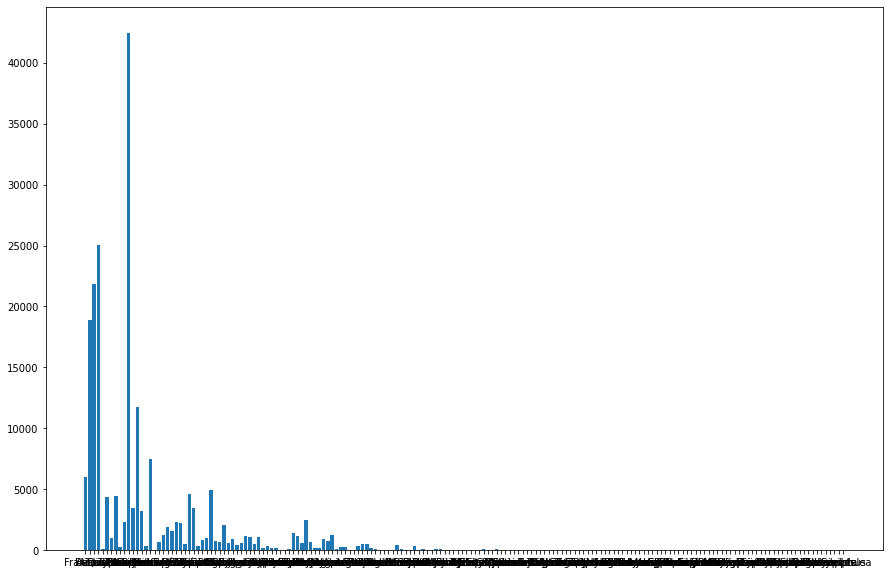

In [19]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = [15, 10]

cumulsd = dict(cumuls)

x, y = zip(*cumulsd.items()) # unpack a list of pairs into two tuples
plt.bar(x, y)
plt.show()